In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator


import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.
/Users/bmmorris/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


[798. 725. 480.]
[0 1 2]


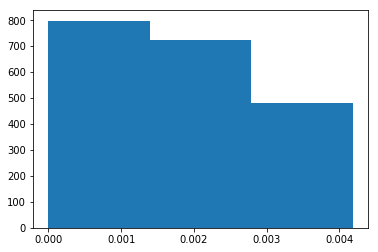

In [121]:
spot_coverages = np.load('data/all_fs.npy')

bin_edges = np.linspace(0, spot_coverages.max(), 4)

n = plt.hist(spot_coverages, bin_edges)[0]; 
print(n)
bin_inds = np.digitize(spot_coverages, bin_edges, right=True) - 1
print(np.unique(bin_inds))

In [122]:
train_X = np.load('data/residuals.npy')[:-1, :, np.newaxis]

train_Y = bin_inds

print('Training data shape : ', train_X.shape, train_Y.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

train_X = train_X.astype('float32')

from keras.utils import to_categorical

train_Y_one_hot = to_categorical(train_Y)

Training data shape :  (2003, 2000, 1) (2003,)
Total number of outputs :  3
Output classes :  [0 1 2]


In [123]:
from sklearn.model_selection import train_test_split

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, 
                                                              test_size=0.2, random_state=0)

In [124]:
train_label.sum(0)

array([644., 582., 376.], dtype=float32)

In [125]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((1602, 2000, 1), (401, 2000, 1), (1602, 3), (401, 3))

In [126]:
alpha = 0.1
kernel_size = 5
dropout_rate = 0.5
activation = 'linear'
padding = 'same'

batch_size = 64
epochs = 75
num_classes = train_Y_one_hot.shape[1]

model = Sequential()

# First layer
model.add(Conv1D(filters=32, kernel_size=kernel_size, activation=activation, 
                 input_shape=(train_X.shape[1], 1), padding=padding))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling1D(2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# # Second layer
# model.add(Conv1D(filters=64, kernel_size=kernel_size, 
#                  activation=activation, padding=padding))
# model.add(LeakyReLU(alpha=alpha))
# model.add(MaxPooling1D(pool_size=2, padding=padding))
# model.add(BatchNormalization())
# model.add(Dropout(dropout_rate))

# # Third layer
# model.add(Conv1D(filters=128, kernel_size=kernel_size, 
#                  activation=activation, padding=padding))
# model.add(LeakyReLU(alpha=alpha))                  
# model.add(MaxPooling1D(pool_size=2, padding=padding))
# model.add(BatchNormalization())
# model.add(Dropout(dropout_rate))

# # fourth layer
# model.add(Conv1D(filters=128, kernel_size=kernel_size, 
#                  activation=activation, padding=padding))
# model.add(LeakyReLU(alpha=alpha))                  
# model.add(MaxPooling1D(pool_size=2, padding=padding))
# model.add(BatchNormalization())
# model.add(Dropout(dropout_rate))

# Fully connected layer 1
model.add(Flatten())
model.add(Dense(128, activation=activation))
model.add(LeakyReLU(alpha=alpha))

# Fully connected layer 2
model.add(Dense(128, activation=activation))
model.add(LeakyReLU(alpha=alpha))

# Fully connected layer 2
# model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [127]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 2000, 32)          192       
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 2000, 32)          0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 1000, 32)          0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 1000, 32)          128       
_________________________________________________________________
dropout_64 (Dropout)         (None, 1000, 32)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 32000)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               4096128   
__________

In [128]:
train = model.fit(train_X, train_label, batch_size=batch_size, 
                  epochs=epochs, validation_data=(valid_X, valid_label))

Train on 1602 samples, validate on 401 samples
Epoch 1/75
1602/1602 [==============================] - 8s 5ms/step - loss: 9.0772 - acc: 0.3708 - val_loss: 9.7598 - val_acc: 0.3791
Epoch 2/75
1602/1602 [==============================] - 3s 2ms/step - loss: 9.6993 - acc: 0.3752 - val_loss: 9.7567 - val_acc: 0.3716
Epoch 3/75
1602/1602 [==============================] - 3s 2ms/step - loss: 9.6920 - acc: 0.3808 - val_loss: 9.7472 - val_acc: 0.3791
Epoch 4/75
1602/1602 [==============================] - 3s 2ms/step - loss: 9.6944 - acc: 0.3795 - val_loss: 9.7286 - val_acc: 0.3791
Epoch 5/75
1602/1602 [==============================] - 3s 2ms/step - loss: 9.6921 - acc: 0.3745 - val_loss: 9.7297 - val_acc: 0.3791
Epoch 6/75
1602/1602 [==============================] - 3s 2ms/step - loss: 9.6886 - acc: 0.3795 - val_loss: 9.7312 - val_acc: 0.3716
Epoch 7/75
1602/1602 [==============================] - 3s 2ms/step - loss: 9.6881 - acc: 0.3801 - val_loss: 9.7199 - val_acc: 0.3840
Epoch 8/75
1602

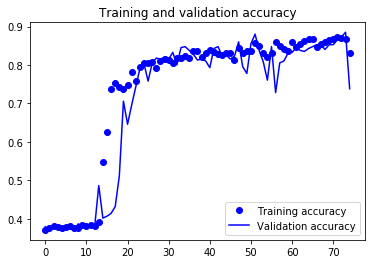

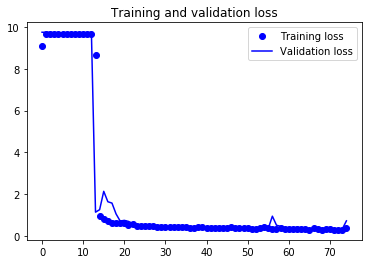

In [129]:
accuracy = train.history['acc']
val_accuracy = train.history['val_acc']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [130]:
model.save('data/model.hdf5')

In [131]:
all_residuals = np.load('data/residuals.npy')[:-1, :, np.newaxis]
wavelengths = np.load('data/residuals_wl.npy')
pred_y = model.predict(all_residuals)

In [132]:
low_spots = all_residuals[pred_y.argmax(1) == 0]
mid_spots = all_residuals[pred_y.argmax(1) == 1]
high_spots = all_residuals[pred_y.argmax(1) == 2]

In [133]:
np.unique(pred_y.argmax(1))

array([0, 1, 2])

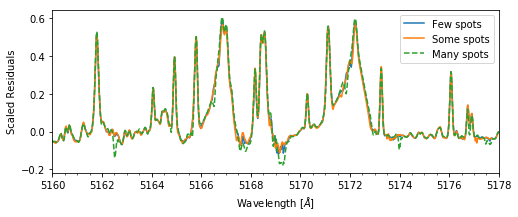

In [137]:
fig, ax = plt.subplots(figsize=(8, 3), sharex=True)

props = dict(alpha=1)

ax.plot(wavelengths, np.median(low_spots[:, :, 0].T, axis=1), label='Few spots', **props);

ax.plot(wavelengths, np.median(mid_spots[:, :, 0].T, axis=1), label='Some spots', **props);

ax.plot(wavelengths, np.median(high_spots[:, :, 0].T, axis=1), ls='--', label='Many spots', **props);

ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_xlim([5160, 5178])
ax.set(xlabel='Wavelength [$\AA$]', ylabel='Scaled Residuals')
plt.legend()
fig.savefig('plots/solar_categories.pdf', bbox_inches='tight')

In [102]:
# fig, ax = plt.subplots(3, 1, figsize=(14, 4), sharex=True)

# props = dict(alpha=0.01)

# plt.plot(low_spots[:, :, 0].T, color='C0', **props);

# plt.plot(mid_spots[:, :, 0].T, color='C1', **props);

# plt.plot(high_spots[:, :, 0].T, color='C2', **props);